# LuSEE-Night Simulation
#### David W. Barker
## Purpose
The purpose of this notebook is to create a LuSEE-Night simulation (end-to-end). There are two primary things being done in this simulation: 1) a simulated signal and 2) a large number of simulated signals with varying parameters that create the traning sets. You then see if your training set's eigen vectors can model the arbitrary simulated signal. That's the main goal.

In [1]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
import py21cmfast as p21c
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import ares
import camb

## The 21 cm Signal
Our first step is to create a training set for the 21 cm signal. This should include not only differences in the cosmological parameters, but also phenomenological models of increase heating and cooling.

### STEP 1: Code Up An Analytical Solution to the Dark Ages Signal.

#### Step 1.1: Derive an analytical solution for the Dark Ages signal.
We did this in our "Derivations for Comps" notebook, so let's repeat what we need here:

- $\delta T_{b}(\nu)=\frac{T_{b}(\nu)-T_{\gamma(\nu)}}{1+z}$ (1)

However, this is perhaps unneccesary (or very neccesary, not sure) so let's simplify to the following:

- $\delta T_{b} = T_{S} - T_{\gamma}$ (2)

where $T_{S}$ is the spin temperature and $T_{\gamma}$ is the CMB temperature. Now lets start the process of expanding these terms out until we get to the point that we can plug in constants and code this up:

- $T_{S} = \frac{1+x_{c}}{{\frac{1}{T_{\gamma}}+\frac{x_{c}}{T_{k}}}}$ (3)

We have $T_{\gamma}$:

- $T_{\gamma} = T_{\gamma,0}(1+z) = 2.725(1+z)K $  (4)

where z is our independent variable and $T_{\gamma,0}$ = 2.725 K. Still need $x_{c}$ and $T_{k}$:

- $x_{c}^{i}\equiv \frac{C_{10}^{i}}{A_{10}}\frac{T_{\star}}{T_{\gamma}} = \frac{n_{i}k_{10}^{i}}{A_{10}}\frac{T_{\star}}{T_{\gamma}}$ (5)

the i denotes the different collision species. The two we care about the most are other Hydrogen atoms and free electrons. There are other things like Helium (only ionized helium due to spin conservation) and Deuterium, but they are very minimal in their contribution. If we are way off with our calculation, this approximation doesn't seem a likely culprit, but it's good to keep in mind that it is, in fact, an approximation. So if we consider the two species:

- $x_{c} = \frac{T_{\star}}{T_{\gamma}A_{10}}(n_{H}\kappa_{10}^{HH}+n_{e}\kappa_{10}^{eH})$ (6)

where $HH$ means collisions between hydrogen atoms and $eH$ means collisions between hydrogen and free electrons. We still need the $n$ 's: I don't love that I'm still ignoring Helium, even when considering number density, but I see that in the literature, so maybe it's okay to do.  If our signal is way off this might be a good place to start to correct approximations.

- $n_{e} = n_{b}x_{e}$ (7)

- $n_{H} = n_{b}(1-x_{e})$ (8)

- $n_{b} = n_{b,0}(1+z)^{3} = 2.06 \times 10^{-7}(1+z)^3$ $\frac{baryons}{cm^{3}} $ (9)

where $n_{b,0}=2.06 \times 10^{-7}$ $\frac{baryons}{cm^{3}} $ (10)

We will grab $x_{e}$ from CosmoRec. Here are some important constants and formulas we know that will allow us to get to an $x_{c}$ that is actually programmable:

- $A_{10} = 2.85 \times 10^{-15}$ $s^{-1}$ (11)

- $T_{\star} = 0.068$ $K$ (12)

- $\kappa_{10}^{HH}$ will be interpolated from a table on pg. 29 of Furlanetto, et al. 2006b (13)

- $\kappa_{10}^{eH}$ will be interpolated from a table on pg. 30 of Furlanetto, et al. 2006b (14)

And now we have all we need to get to something programmable:

- $x_{c} = \frac{T_{\star}}{T_{\gamma,0}(1+z)A_{10}}(n_{H}\kappa_{10}^{HH}+n_{e}\kappa_{10}^{eH})$ (15)

- $T_{S} = \frac{1+x_{c}}{{\frac{1}{T_{\gamma,0}(1+z)}+\frac{x_{c}}{T_{k}}}}$ (16)

- $\frac{dT_{k}}{dt} = \frac{x_{e}}{1+x_{e}}\frac{(T_{\gamma,0}(1+z)-T_{k})}{t_{c}}-2T_{k}H$ (17)

For our initial test, I'm not going to bother running any code for $T_{k}$ I'm going to let CosmoRec handle that. Once wer're confident everything else works, we can add in our own $T_{k}$ calculator so that we may add some phenomenological shananigans to it later on if we desire (and also prove I understand what's going on and can code it up).

Okay, so let's code up equations 2, 15, and 16, and use CosmoRec for $T_{k}$ for now and see what we get.

In [16]:
# Parameters
H0 = 67.36     # Hubble constant
h = 0.6736
omm = 0.3152   # Omega matter
omb = 0.0493   # Omega baryons
omc = 0.2645   # Omega cold dark matter
z_array = np.arange(20,1100)
n_b0 = 2.06e-7   #[baryons per cubic centimeter] This actually a function of Omega baryons, but I don't want to figure that out right now (just want to prove it works first).
T_gamma0 = 2.725   # [Kelvin] modern CMB temperature
T_star = 0.068    # [Kelvin] the temperature equivalent of the energy difference of the 21 cm hyperfine spin states
A_10 = 2.85e-15    # [inverse seconds] Einstein coefficient for the spontaneous emission of the hyperfine spin states
# Less neccesary (or at least less understood by me but needed by some code)
As = 2.099e-9  # Amplitude of a power spectrum of adiabatic perturbations
ns = 0.9649    # Spectra index of a power spectrum of adiabatic perturbations

In [35]:
# x_e
# for starters, I'm just going to use CosmoRec. We'll use camb later so it's more flawlessly integrated into python

CosmoRec_raw=np.genfromtxt("CosmoRec.dat")
CosmoRec_xe = scipy.interpolate.interp1d(CosmoRec_raw.transpose()[0],CosmoRec_raw.transpose()[1])   # Needs a redshift argument
CosmoRec_Tk = scipy.interpolate.interp1d(CosmoRec_raw.transpose()[0],CosmoRec_raw.transpose()[2])   # Needs a redshift argument


In [58]:
### Here is the stuff that generally doesn't change

## Here are the k tables from Furlanetto 2006b

k_HH_raw = np.array([[1,1.38e-13],[2,1.43e-13],[4,2.71e-13],[6,6.60e-13],[8,1.47e-12],[10,2.88e-12],[15,9.10e-12],[20,1.78e-11],[25,2.73e-11],[30,3.67e-11],[40,5.38e-11],[50,6.86e-11],[60,8.14e-11],[70,9.25e-11],\
                 [80,1.02e-10],[90,1.11e-10],[100,1.19e-10],[200,1.75e-10],[300,2.09e-10],[500,2.56e-10],[700,2.91e-10],[1000,3.31e-10],[2000,4.27e-10],[3000,4.97e-10],[5000,6.03e-10]])
k_eH_raw = np.array([[1, 2.39e-10],[2,3.37e-10],[5,5.30e-10],[10,7.46e-10],[20,1.05e-9],[50,1.63e-9],[100,2.26e-9],[200,3.11e-9],[500,4.59e-9],[1000,5.92e-9],[2000,7.15e-9],[3000,7.71e-9],[5000,8.17e-9]])

# let's write a function that interpolates this table given whatever value we put in.
k_HH = scipy.interpolate.CubicSpline(k_HH_raw.transpose()[0],k_HH_raw.transpose()[1])   # Needs a temperature (or array of temps) as an argument
k_eH = scipy.interpolate.CubicSpline(k_eH_raw.transpose()[0],k_eH_raw.transpose()[1])   # Needs a temperature (or array of temps) as an argument

## n_H and n_e

n_H = lambda z,x_e: n_b0*(1+z)**3*(1-x_e(z))
n_e = lambda z,x_e: n_b0*(1+z)**3*(x_e(z))


In [59]:
# x_c
x_c = lambda z,x_e,T_k: (T_star)/(T_gamma0*(1+z)*A_10)*(n_H(z,x_e)*k_HH(T_k(z)+n_e(z,x_e)))

In [60]:
# T_S

T_S = lambda z,x_e,T_k: (1+x_c(z,x_e,T_k))/((1/(T_gamma0*(1+z)))+(x_c(z,x_e,T_k)/T_k(z)))

In [93]:
# Let's clean this up later, but this is the actual difference from the CMB with the optical depth included

db = lambda z,x_e,T_k: 27*(1-x_e(z))*((h**2*omb)/(0.023))*((0.15)/(h**2*omm))*((1+z)/(10))**(1/2)*(1-((T_gamma0*(1+z))/(T_S(z,x_e,T_k))))

In [ ]:
frequencies_ares=np.delete(frequencies_ares,996)
dTb = np.delete(dTb,996)
import scipy
test_data=scipy.interpolate.CubicSpline(frequencies_ares,dTb)(np.arange(3,200))

In [89]:
db(z_array,CosmoRec_xe,CosmoRec_Tk)

array([-0.37312641, -0.52314208, -0.72010838, ..., -0.00279423,
       -0.00276155, -0.0027282 ])

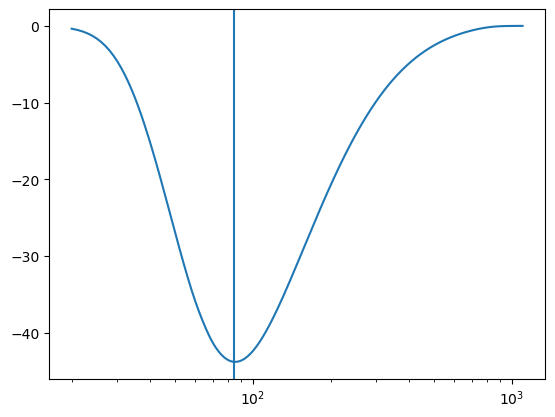

In [97]:
plt.plot(z_array,db(z_array,CosmoRec_xe,CosmoRec_Tk))
plt.axvline(85)
plt.xscale("log")

In [68]:
T_S(1100,CosmoRec_xe,CosmoRec_Tk)

3000.19226369128

In [69]:
T_gamma0*(1+1100)

3000.225

In [65]:
x_c(z_array,CosmoRec_xe,CosmoRec_Tk)

array([1.80482259e-03, 2.60946505e-03, 3.70111713e-03, ...,
       9.32122395e+02, 9.32715132e+02, 9.33293584e+02])

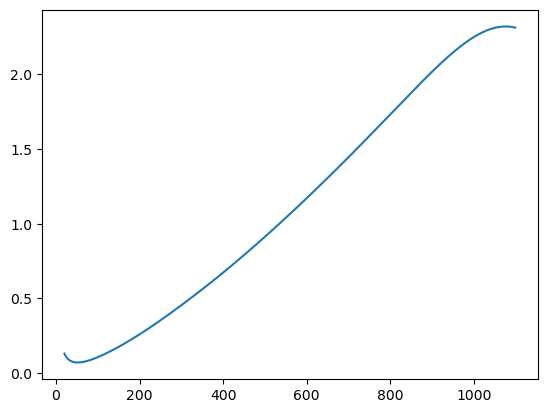

In [19]:
plt.plot(z_array,T_S(z_array,CosmoRec_xe,CosmoRec_Tk))

In [ ]:
/CosmoRec_Tk(1100)

0.0003333119769239319

In [24]:
# This CosmoRec file is a temporary use. I'm not going to calculate T_k yet. I'll use something that I know is right first.  This also includes x_e.
CosmoRec=np.genfromtxt("CosmoRec.dat")


In [86]:
# x_c


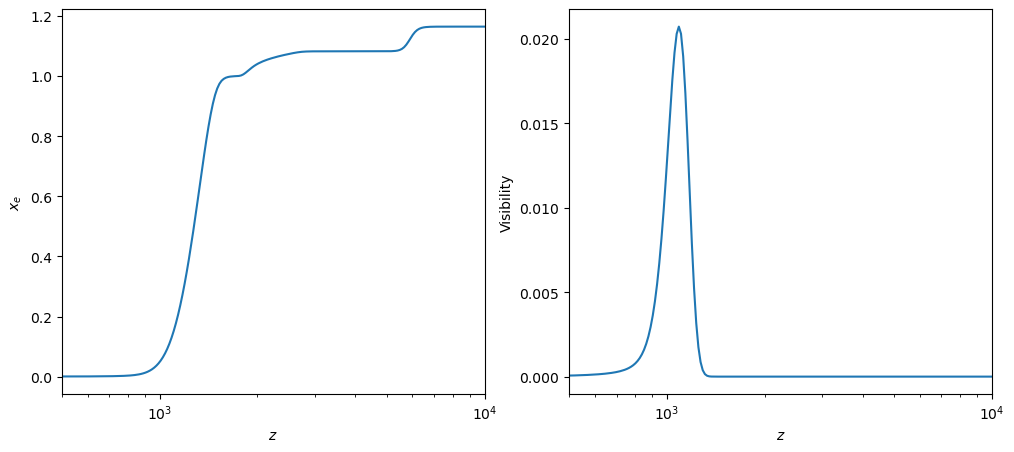

In [23]:
### I'm not going to mess with this just yet. It's a much better way to get x_e that doesn't require an outside program (all through python)

#set_params is a shortcut routine for setting many things at once
pars = camb.set_params(H0=H0, ombh2=omb*h**2, omch2=omc*h**2, As=As, ns=ns)
data= camb.get_background(pars)
#or as a function of redshift
z = 10**np.linspace(2, 4, 300)
back_ev = data.get_background_redshift_evolution(z, ['x_e', 'visibility'], format='array')
fig, axs= plt.subplots(1,2, figsize=(12,5))
for i, (ax, label), in enumerate(zip(axs, ['$x_e$','Visibility'])):
    ax.semilogx(z, back_ev[:,i])
    ax.set_xlabel('$z$')
    ax.set_ylabel(label)
    ax.set_xlim([500,1e4])

In [13]:
back_ev?

Type:        dict
String form:
{'x_e': array([1.16403355e+00, 1.16403355e+00, 1.16403355e+00, 1.16403355e+00,
           1.16403355e <...> 722e-06, 3.43386333e-06,
           3.12838420e-06, 2.84811249e-06, 2.59094633e-06, 2.35495051e-06])}
Length:      2
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

### OLD STEP 1: Change ARES Cosmological Parameters.

In [7]:
cosmology=ares.ares.physics.Cosmology()

In [8]:
cosmology._planck_raw["H0"] = 20
cosmology._planck_raw["omega_m_0"]

KeyError: 'omega_m_0'

In [23]:
cosmology._planck_raw["H0"]

20

In [93]:
# let's see if we can extract cooling rates:
cooling_rates = np.array([])
x_vals = np.arange(1,100,0.1)
for i in x_vals:
    element = cosmology.cooling_rate(i)
    cooling_rates = np.append(cooling_rates,element)

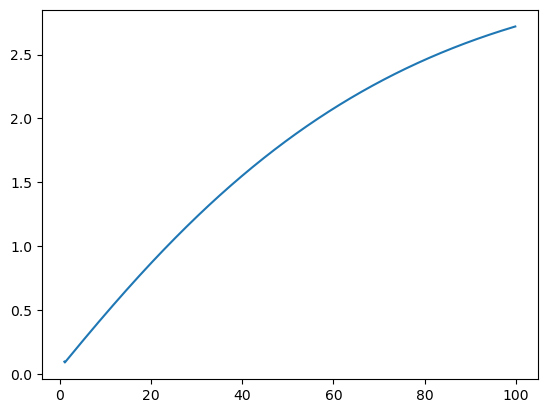

In [94]:
plt.plot(x_vals,cooling_rates)

So from here we know how to extract the cooling rates, but can we reassign these rates and have ARES run a different sim?

In [3]:
cosmo_sig=ares.simulations.Global21cm?
cosmo_sig.run()

NameError: name 'cosmo_sig' is not defined

Init signature: ares.simulations.Global21cm(**kwargs)
Docstring:     
This class must be inherited by another class, which need only have the
``pf`` attribute.

The three most (only) important parameters are:
    blob_names
    blob_ivars
    blob_funcs
    
Init docstring:
Set up a two-zone model for the global 21-cm signal.

..note :: This is essentially a MultiPhaseMedium calculation, except
    the Lyman alpha background and 21-cm background are calculated,
    and alternative (phenomenological) parameterizations such as a
    tanh for the ionization, thermal, and LW background evolution,
    may be used.
File:           ~/ares/ares/simulations/Global21cm.py
Type:           type
Subclasses:     

In [ ]:
cosmo_sig.cosm

TypeError: 'Cosmology' object is not subscriptable

In [3]:
dTb=cosmo_sig.history["dTb"][10]
z=cosmo_sig.history["z"]

In [4]:
dTb

-8.678422985589948e-06

In [6]:
pip install pycamb

ERROR: Could not find a version that satisfies the requirement pycamb (from versions: none)
ERROR: No matching distribution found for pycamb
Note: you may need to restart the kernel to use updated packages.


In [8]:
import camb

In [9]:
from hmf import MassFunction

In [11]:
hmf.wdm.MassFunctionWDM

hmf.alternatives.wdm.MassFunctionWDM

In [2]:
def_kwargs = \
{
 "hmf_model": 'PS',
 "hmf_logMmin": 4,
 "hmf_logMmax": 18,
 "hmf_dlogM": 0.01,

 "hmf_fmt": 'hdf5',
 "hmf_table": None,
 "hmf_wdm_mass": None,

 #"hmf_window": 'sharpk',

 # Redshift sampling
 "hmf_zmin": 0.,
 "hmf_zmax": 60.,
 "hmf_dz": 0.05,

 # Can do constant timestep instead of constant dz
 #"hmf_dt": 1,
 #"hmf_tmin": 30.,
 #"hmf_tmax": 1000.,

 # Cosmology
 "cosmology_id": 'best',
 "cosmology_name": 'planck_TTTEEE_lowl_lowE',

 #HMF params and filter params are for doing Aurel Schneider's 2015 paper WDM.
 #"hmf_params" : {'a' : 1.0},
 #"filter_params" : {'c' : 2.5}

 #"cosmology_id": 'paul',
 #"cosmology_name": 'user',
 "sigma_8": 0.8159,
 'primordial_index': 0.9652,
 'omega_m_0': 0.315579,
 'omega_b_0': 0.0491,
 'hubble_0': 0.6726,
 'omega_l_0': 1. - 0.315579,

}

##

kwargs = def_kwargs.copy()

hmf = ares.physics.HaloMassFunction(hmf_analytic=False,
    hmf_load=False, **kwargs)

In [3]:
import hmf